In [51]:
from tensorflow.compat.v1 import ConfigProto, GPUOptions, InteractiveSession

if 'session' in globals():
    print('Session close and recreate')
    session.close()

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Session close and recreate


In [52]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [53]:
(x_tr, y_train), (x_ts, y_test)=tf.keras.datasets.imdb.load_data(num_words=2000)

In [54]:
def filter_datasets(xs,ys,length):
    xs_res=[]
    ys_res=[]
    iter_range=xs.shape[0]
    for i in range (iter_range):
        if len(xs[i]) >=length:
            xs_res.append(xs[i])
            ys_res.append(ys[i])
    return np.asarray(xs_res),np.asarray(ys_res)

In [55]:
x_tr, y_train=filter_datasets(x_tr, y_train,100)
x_ts, y_test=filter_datasets(x_ts, y_test,100)

In [56]:
x_train=tf.keras.preprocessing.sequence.pad_sequences(x_tr,maxlen=100,truncating='post',padding='post')
x_test=tf.keras.preprocessing.sequence.pad_sequences(x_ts,maxlen=100,truncating='post',padding='post')

In [57]:
x_test.shape

(22037, 100)

In [58]:
x_train=x_train[0:22200]
y_train=y_train[0:22200]
x_test=x_test[0:22000]
y_test=y_test[0:22000]

In [59]:
words_dictionary=tf.keras.datasets.imdb.get_word_index()
reversed_dictionary = dict(zip(words_dictionary.values(),words_dictionary.keys()))

In [60]:
vocabulary_size=len(words_dictionary)

In [61]:
vocabulary_size

88584

In [62]:
embeddings_index = dict()
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [64]:
embedding_matrix = np.zeros((vocabulary_size, 300))
for index in range(vocabulary_size):
    embedding_vector = embeddings_index.get(reversed_dictionary[index+1])
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [65]:
embedding_matrix[0].shape

(300,)

In [66]:
class RNNCell(tf.keras.layers.Layer):
    """Simple RNN cell
    """
    def __init__(self,input_size,output_size):
        """Inits the class."""
        super(RNNCell, self).__init__()
        self.w = self.add_weight(shape=(input_size+output_size,output_size),
                             initializer='random_uniform',
                             trainable=True)
        self.b = self.add_weight(shape=(1,output_size),
                             initializer='random_uniform',
                             trainable=True)
        self.activation_function=tf.keras.backend.tanh
        
    #przyjmuje : wyjścia z kroku poprzedniego: batchxoutput, nowe wejścia [batchxembedding]
    #returns batchxoutput
    def call(self, outputs,inputs):
        """Makes forward pass of the layer"""
        concat=K.concatenate((tf.dtypes.cast(outputs, tf.float32),tf.dtypes.cast(inputs, tf.float32)), axis=-1)
        output=self.activation_function(tf.matmul(concat, self.w) + self.b)      
        return output
    
    

In [67]:
class RNNModel(tf.keras.Model):
    """
    """
    def __init__(self,batch_size=100,output_size=32,custom_embedding_layer=False):
        super(RNNModel, self).__init__()
        if custom_embedding_layer:
            self.embedding_layer=tf.keras.layers.Embedding(88584,300,input_length=100, weights=[embedding_matrix], trainable=False)
        else:
            self.embedding_layer=tf.keras.layers.Embedding(88584,300,input_length=100,embeddings_initializer='uniform') 
        self.cell=RNNCell(300,output_size)
        self.dense_layer=tf.keras.layers.Dense(2, activation='softmax')

        self.batch_size=batch_size
        self.output_size=output_size
        
        self.train_learning_accuracy=[]
        self.test_learning_accuracy=[]
        self.train_learning_losses=[]
        self.test_learning_losses=[]

    
    def call(self, inputs, training=False):
        inputs=self.embedding_layer(inputs)
        inputs=tf.transpose(inputs,perm=[1, 0, 2])
        outputs=tf.zeros((self.batch_size,self.output_size))
        for timestep_inputs in inputs:
            outputs=self.cell(outputs,timestep_inputs)
        return self.dense_layer(outputs)
    
    @tf.function
    def train_step(self,sequences, labels,loss_function,optimizer, train_loss_metric,train_accuracy):
        with tf.GradientTape() as tape:
            predictions = self(sequences)
            loss = loss_function(labels, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        train_loss_metric(loss)
        train_accuracy(labels, predictions)
        
    @tf.function
    def test_step(self,images, labels,loss_function,test_loss_metric,test_accuracy):
        predictions = self(images)
        t_loss = loss_function(labels, predictions)
        test_loss_metric(t_loss)
        test_accuracy(labels, predictions)

    def fit(self,train_xs,train_ys,test_xs,test_ys,loss_function=tf.keras.losses.SparseCategoricalCrossentropy,
            epochs=10,optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
        
        train_ds = tf.data.Dataset.from_tensor_slices((train_xs,train_ys)).shuffle(5000).batch(self.batch_size)
        
        test_ds = tf.data.Dataset.from_tensor_slices((test_xs, test_ys)).batch(self.batch_size)
        
        loss_function=loss_function()
        
        self.train_learning_accuracy=[]
        self.test_learning_accuracy=[]
        self.train_learning_losses=[]
        self.test_learning_losses=[]

        train_loss_metric = tf.keras.metrics.Mean(name='train_loss_metric')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        test_loss_metric = tf.keras.metrics.Mean(name='test_loss_metric')
        test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
        
        for epoch in tqdm(range(epochs)):
            for batch_seq,batch_labels in train_ds:
                self.train_step(batch_seq, batch_labels,loss_function,optimizer,train_loss_metric,train_accuracy)

            for test_images, test_labels in test_ds:
                self.test_step(test_images, test_labels,loss_function,test_loss_metric,test_accuracy)

            template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
            print(template.format(epoch+1,
                        train_loss_metric.result(),
                        train_accuracy.result()*100,
                        test_loss_metric.result(),
                        test_accuracy.result()*100))
            self.train_learning_accuracy.append(train_accuracy.result().numpy()*100)
            self.test_learning_accuracy.append(test_accuracy.result().numpy()*100)
            self.train_learning_losses.append(train_loss_metric.result().numpy())
            self.test_learning_losses.append(test_loss_metric.result().numpy())

            # Reset the metrics for the next epoch
            train_loss_metric.reset_states()
            train_accuracy.reset_states()
            test_loss_metric.reset_states()
            test_accuracy.reset_states()
    
    def predict(self, x):
        return np.argmax(self(x),axis=-1)

In [68]:
class LSTMCell(tf.keras.layers.Layer):
    """Simple LSTM cell
    """
    def __init__(self,input_size,output_size):
        """Inits the class."""
        super(LSTMCell, self).__init__()
        self.Wf = self.add_weight(shape=(input_size+output_size,output_size),
                             initializer='random_uniform',
                             trainable=True)
        self.Bf = self.add_weight(shape=(1,output_size),
                             initializer='random_uniform',
                             trainable=True)
        self.Wi = self.add_weight(shape=(input_size+output_size,output_size),
                             initializer='random_uniform',
                             trainable=True)
        self.Bi = self.add_weight(shape=(1,output_size),
                             initializer='random_uniform',
                             trainable=True)
        self.Wc = self.add_weight(shape=(input_size+output_size,output_size),
                             initializer='random_uniform',
                             trainable=True)
        self.Bc = self.add_weight(shape=(1,output_size),
                             initializer='random_uniform',
                             trainable=True)
        self.Wo = self.add_weight(shape=(input_size+output_size,output_size),
                             initializer='random_uniform',
                             trainable=True)
        self.Bo = self.add_weight(shape=(1,output_size),
                             initializer='random_uniform',
                             trainable=True)
        self.tanh=K.tanh
        self.sigmoid=K.sigmoid

    #działa na jednym timestepie
    #przyjmuje : wyjścia z kroku poprzedniego: batchxoutput, nowe wejścia [batchxembedding]
    #returns batchxoutput
    def call(self, outputs,signals,inputs):
        """Makes forward pass of the layer"""
        concat=K.concatenate((tf.dtypes.cast(outputs, tf.float32),tf.dtypes.cast(inputs, tf.float32)), axis=-1)
        ft=self.sigmoid(tf.matmul(concat, self.Wf) + self.Bf)
        it=self.sigmoid(tf.matmul(concat, self.Wi) + self.Bi)
        Ct1=self.tanh(tf.matmul(concat, self.Wc) + self.Bc)
        Ct=tf.math.multiply(ft,signals)+tf.math.multiply(it,Ct1)
        ot=self.sigmoid(tf.matmul(concat, self.Wo) + self.Bo)
        ht=tf.math.multiply(ot,self.tanh(Ct))
        return ht,Ct

In [69]:
class LSTMModel(tf.keras.Model):
    """
    """
    def __init__(self,batch_size=100,output_size=32,custom_embedding_layer=True):
        super(LSTMModel, self).__init__()
        if custom_embedding_layer:
            self.embedding_layer=tf.keras.layers.Embedding(88584,300,input_length=100, weights=[embedding_matrix], trainable=False)
        else:
            self.embedding_layer=tf.keras.layers.Embedding(88584,300,input_length=100,embeddings_initializer='uniform')   
        self.cell=LSTMCell(300,output_size)
        self.dense_layer=tf.keras.layers.Dense(2, activation='softmax')

        self.batch_size=batch_size
        self.output_size=output_size
        
        self.train_learning_accuracy=[]
        self.test_learning_accuracy=[]
        self.train_learning_losses=[]
        self.test_learning_losses=[]

    
    def call(self, inputs, training=False):
        inputs=self.embedding_layer(inputs)
        inputs=tf.transpose(inputs,perm=[1, 0, 2])
        outputs=tf.zeros((self.batch_size,self.output_size))
        signals=outputs=tf.zeros((self.batch_size,self.output_size))
        for timestep_inputs in inputs:
            outputs,signals=self.cell(outputs,signals,timestep_inputs)
        return self.dense_layer(outputs)
    
    @tf.function
    def train_step(self,sequences, labels,loss_function,optimizer, train_loss_metric,train_accuracy):
        with tf.GradientTape() as tape:
            predictions = self(sequences)
            loss = loss_function(labels, predictions)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        train_loss_metric(loss)
        train_accuracy(labels, predictions)
        
    @tf.function
    def test_step(self,images, labels,loss_function,test_loss_metric,test_accuracy):
        predictions = self(images)
        t_loss = loss_function(labels, predictions)
        test_loss_metric(t_loss)
        test_accuracy(labels, predictions)

    def fit(self,train_xs,train_ys,test_xs,test_ys,loss_function=tf.keras.losses.SparseCategoricalCrossentropy,
            epochs=10,optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)):
        
        train_ds = tf.data.Dataset.from_tensor_slices((train_xs,train_ys)).shuffle(5000).batch(self.batch_size)
        
        test_ds = tf.data.Dataset.from_tensor_slices((test_xs, test_ys)).batch(self.batch_size)
        
        loss_function=loss_function()
        
        self.train_learning_accuracy=[]
        self.test_learning_accuracy=[]
        self.train_learning_losses=[]
        self.test_learning_losses=[]

        train_loss_metric = tf.keras.metrics.Mean(name='train_loss_metric')
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        test_loss_metric = tf.keras.metrics.Mean(name='test_loss_metric')
        test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
        
        for epoch in tqdm(range(epochs)):
            for batch_seq,batch_labels in train_ds:
                self.train_step(batch_seq, batch_labels,loss_function,optimizer,train_loss_metric,train_accuracy)

            for test_images, test_labels in test_ds:
                self.test_step(test_images, test_labels,loss_function,test_loss_metric,test_accuracy)

            template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
            print(template.format(epoch+1,
                        train_loss_metric.result(),
                        train_accuracy.result()*100,
                        test_loss_metric.result(),
                        test_accuracy.result()*100))
            self.train_learning_accuracy.append(train_accuracy.result().numpy()*100)
            self.test_learning_accuracy.append(test_accuracy.result().numpy()*100)
            self.train_learning_losses.append(train_loss_metric.result().numpy())
            self.test_learning_losses.append(test_loss_metric.result().numpy())

            # Reset the metrics for the next epoch
            train_loss_metric.reset_states()
            train_accuracy.reset_states()
            test_loss_metric.reset_states()
            test_accuracy.reset_states()
    
    def predict(self, x):
        return np.argmax(self(x),axis=-1)

## Hyperparameters exploration

In [49]:
def run_tests(file_name):
    EPOCHS=10
    OUTPUT_SIZES=[16,32]
    BATCHES=[50,100]
    MODELS=[RNNModel,LSTMModel]
    MODELS_DESC=['RNN','LSTM']
    CUSTOM_EMBEDDING=[True,False]
    OPTIMIZERS=[tf.optimizers.Adam(learning_rate=0.001),tf.optimizers.Adam(learning_rate=0.0001)]
    OPTIMS_DESC=['ADAM,0.001','ADAM,0.0001']
    
    cols=['EPOCHS','MODEL','CUSTOM EMBEDDING','OPTIM','OUTPUT_SIZE','BATCH_SIZE','ACC_TRAIN','ACC_TEST','ERROR_TRAIN','ERROR_TEST']
    df = pd.DataFrame(columns=cols)
    df.to_csv('./csv/' + file_name + '.csv',index=False)
    for model in MODELS:
        model_desc=MODELS_DESC[MODELS.index(model)]
        for custom_embedding in CUSTOM_EMBEDDING:
            for optim in OPTIMIZERS:
                optim_desc=OPTIMS_DESC[OPTIMIZERS.index(optim)]
                for output_size in OUTPUT_SIZES:
                    for batch_size in BATCHES:
                        epochs=EPOCHS
                        if custom_embedding:
                            epochs=15
                        t_model=model(batch_size=batch_size,output_size=output_size,custom_embedding_layer=custom_embedding)
                        t_model.fit(x_train,y_train,x_test,y_test,optimizer=optim,epochs=epochs)
                        for epoch in range(epochs):
                            acc_train=t_model.train_learning_accuracy[epoch]
                            acc_test=t_model.test_learning_accuracy[epoch]
                            error_train=t_model.train_learning_losses[epoch]
                            error_test=t_model.test_learning_losses[epoch]

                            subdf=pd.DataFrame(zip([epoch+1],[model_desc],[custom_embedding],[optim_desc],[output_size],[batch_size],[acc_train],[acc_test],[error_train],[error_test]),
                                               columns=cols)

                            subdf.to_csv('./csv/' + file_name + '.csv', mode='a', header=False, index=False)

In [ ]:
run_tests('research_lstm_v2')

Epoch 1, Loss: 0.6978697180747986, Accuracy: 50.4594612121582, Test Loss: 0.6945657134056091, Test Accuracy: 50.54545593261719
Epoch 2, Loss: 0.6912322640419006, Accuracy: 52.94144058227539, Test Loss: 0.6943324208259583, Test Accuracy: 50.39545440673828
Epoch 3, Loss: 0.6900586485862732, Accuracy: 53.603599548339844, Test Loss: 0.6919043064117432, Test Accuracy: 54.51818084716797
Epoch 4, Loss: 0.6892220377922058, Accuracy: 53.621620178222656, Test Loss: 0.6947879195213318, Test Accuracy: 50.9227294921875
Epoch 5, Loss: 0.6898120641708374, Accuracy: 52.923423767089844, Test Loss: 0.6934338212013245, Test Accuracy: 51.004547119140625
Epoch 6, Loss: 0.6899139881134033, Accuracy: 52.69820022583008, Test Loss: 0.6969539523124695, Test Accuracy: 50.977272033691406
Epoch 7, Loss: 0.6878176927566528, Accuracy: 53.9954948425293, Test Loss: 0.7012823224067688, Test Accuracy: 51.068180084228516
Epoch 8, Loss: 0.6860647797584534, Accuracy: 54.387386322021484, Test Loss: 0.6933656930923462, Test 

Epoch 1, Loss: 0.698153018951416, Accuracy: 50.75225067138672, Test Loss: 0.6928658485412598, Test Accuracy: 51.345455169677734
Epoch 2, Loss: 0.6891374588012695, Accuracy: 53.58108139038086, Test Loss: 0.6912247538566589, Test Accuracy: 53.53636169433594
Epoch 3, Loss: 0.6878390908241272, Accuracy: 54.20720672607422, Test Loss: 0.694863498210907, Test Accuracy: 50.0590934753418
Epoch 4, Loss: 0.6874278783798218, Accuracy: 54.067569732666016, Test Loss: 0.6909611225128174, Test Accuracy: 53.181819915771484
Epoch 5, Loss: 0.6868882775306702, Accuracy: 54.418922424316406, Test Loss: 0.6942727565765381, Test Accuracy: 50.90454864501953
Epoch 6, Loss: 0.6871310472488403, Accuracy: 54.31531524658203, Test Loss: 0.6913575530052185, Test Accuracy: 53.186363220214844
Epoch 7, Loss: 0.6838138103485107, Accuracy: 55.25675582885742, Test Loss: 0.684980571269989, Test Accuracy: 55.58182144165039
Epoch 8, Loss: 0.6774392127990723, Accuracy: 57.72522735595703, Test Loss: 0.6901389956474304, Test Acc

Epoch 1, Loss: 0.7000588774681091, Accuracy: 50.65315246582031, Test Loss: 0.6928512454032898, Test Accuracy: 51.05000305175781
Epoch 2, Loss: 0.6901586055755615, Accuracy: 53.27477264404297, Test Loss: 0.6940604448318481, Test Accuracy: 51.568180084228516
Epoch 3, Loss: 0.6900303959846497, Accuracy: 52.92792892456055, Test Loss: 0.6931750774383545, Test Accuracy: 51.34090805053711
Epoch 4, Loss: 0.6869950890541077, Accuracy: 54.5945930480957, Test Loss: 0.6935989856719971, Test Accuracy: 50.818180084228516
Epoch 5, Loss: 0.6886805891990662, Accuracy: 53.69820022583008, Test Loss: 0.6858826875686646, Test Accuracy: 55.51363754272461
Epoch 6, Loss: 0.6844589114189148, Accuracy: 55.37837600708008, Test Loss: 0.6876490712165833, Test Accuracy: 55.64091110229492
Epoch 7, Loss: 0.6828976273536682, Accuracy: 56.10360336303711, Test Loss: 0.6994103193283081, Test Accuracy: 52.83636474609375
Epoch 8, Loss: 0.6858506798744202, Accuracy: 54.51802062988281, Test Loss: 0.6956782341003418, Test Acc

Epoch 1, Loss: 0.7000913023948669, Accuracy: 50.24324035644531, Test Loss: 0.693232536315918, Test Accuracy: 51.20454406738281
Epoch 2, Loss: 0.6913087368011475, Accuracy: 52.878379821777344, Test Loss: 0.6935679912567139, Test Accuracy: 50.2136344909668
Epoch 3, Loss: 0.6918392181396484, Accuracy: 52.274776458740234, Test Loss: 0.6941064596176147, Test Accuracy: 50.96818161010742
Epoch 4, Loss: 0.6912994384765625, Accuracy: 52.72071838378906, Test Loss: 0.695079505443573, Test Accuracy: 51.099998474121094
Epoch 5, Loss: 0.6891449689865112, Accuracy: 53.509010314941406, Test Loss: 0.6951705813407898, Test Accuracy: 52.39999771118164
Epoch 6, Loss: 0.687706470489502, Accuracy: 54.297298431396484, Test Loss: 0.6957554817199707, Test Accuracy: 51.318180084228516
Epoch 7, Loss: 0.688227117061615, Accuracy: 53.55405044555664, Test Loss: 0.6945061683654785, Test Accuracy: 50.72272872924805
Epoch 8, Loss: 0.6847926378250122, Accuracy: 54.954952239990234, Test Loss: 0.6945782899856567, Test Ac

Epoch 1, Loss: 0.6961714029312134, Accuracy: 50.27927780151367, Test Loss: 0.6944604516029358, Test Accuracy: 50.38181686401367
Epoch 2, Loss: 0.6926785111427307, Accuracy: 51.55855941772461, Test Loss: 0.6942986845970154, Test Accuracy: 50.495452880859375
Epoch 3, Loss: 0.6913669109344482, Accuracy: 52.23423385620117, Test Loss: 0.6944727301597595, Test Accuracy: 50.804542541503906
Epoch 4, Loss: 0.6907241940498352, Accuracy: 52.71171188354492, Test Loss: 0.6960169076919556, Test Accuracy: 50.663639068603516
Epoch 5, Loss: 0.6900991201400757, Accuracy: 52.75225067138672, Test Loss: 0.6942528486251831, Test Accuracy: 51.06364059448242
Epoch 6, Loss: 0.6893939971923828, Accuracy: 53.11711502075195, Test Loss: 0.6947590708732605, Test Accuracy: 51.19545364379883
Epoch 7, Loss: 0.6886442303657532, Accuracy: 53.725223541259766, Test Loss: 0.6948623657226562, Test Accuracy: 51.54091262817383
Epoch 8, Loss: 0.6878437995910645, Accuracy: 53.693695068359375, Test Loss: 0.6942305564880371, Test

Epoch 1, Loss: 0.6958163380622864, Accuracy: 50.84684371948242, Test Loss: 0.6953076720237732, Test Accuracy: 50.495452880859375
Epoch 2, Loss: 0.6915297508239746, Accuracy: 52.499996185302734, Test Loss: 0.6946484446525574, Test Accuracy: 50.44545364379883
Epoch 3, Loss: 0.6902632713317871, Accuracy: 52.81981658935547, Test Loss: 0.6950051188468933, Test Accuracy: 50.9636344909668
Epoch 4, Loss: 0.6890100836753845, Accuracy: 53.59910202026367, Test Loss: 0.6950761675834656, Test Accuracy: 51.177276611328125
Epoch 5, Loss: 0.6880794167518616, Accuracy: 53.70720672607422, Test Loss: 0.6945064067840576, Test Accuracy: 51.10454559326172
Epoch 6, Loss: 0.6867892742156982, Accuracy: 54.797298431396484, Test Loss: 0.6951802968978882, Test Accuracy: 51.18181610107422
Epoch 7, Loss: 0.6856437921524048, Accuracy: 54.66216278076172, Test Loss: 0.6942782998085022, Test Accuracy: 51.62727355957031
Epoch 8, Loss: 0.6844598650932312, Accuracy: 54.945945739746094, Test Loss: 0.6950455904006958, Test 

Epoch 1, Loss: 0.6963161826133728, Accuracy: 50.28828811645508, Test Loss: 0.693406879901886, Test Accuracy: 51.23636245727539
Epoch 2, Loss: 0.6914037466049194, Accuracy: 52.666664123535156, Test Loss: 0.6936284899711609, Test Accuracy: 51.686363220214844
Epoch 3, Loss: 0.6891680955886841, Accuracy: 53.738739013671875, Test Loss: 0.6941418051719666, Test Accuracy: 51.45454406738281
Epoch 4, Loss: 0.6875180006027222, Accuracy: 54.558555603027344, Test Loss: 0.6947559118270874, Test Accuracy: 51.427276611328125
Epoch 5, Loss: 0.6855214834213257, Accuracy: 54.97747802734375, Test Loss: 0.6927787065505981, Test Accuracy: 52.818180084228516
Epoch 6, Loss: 0.682171106338501, Accuracy: 56.274776458740234, Test Loss: 0.6878191232681274, Test Accuracy: 54.945457458496094
Epoch 7, Loss: 0.6668462157249451, Accuracy: 59.67116928100586, Test Loss: 0.6688458323478699, Test Accuracy: 60.39545440673828
Epoch 8, Loss: 0.6558040976524353, Accuracy: 61.288291931152344, Test Loss: 0.6584852933883667, Te

Epoch 1, Loss: 0.6974418759346008, Accuracy: 50.58108139038086, Test Loss: 0.6958313584327698, Test Accuracy: 50.70000457763672
Epoch 2, Loss: 0.6914370656013489, Accuracy: 52.054054260253906, Test Loss: 0.694606602191925, Test Accuracy: 51.163639068603516
Epoch 3, Loss: 0.6893149018287659, Accuracy: 53.261260986328125, Test Loss: 0.6957827210426331, Test Accuracy: 51.01363754272461
Epoch 4, Loss: 0.6874657869338989, Accuracy: 53.990989685058594, Test Loss: 0.6954604387283325, Test Accuracy: 51.068180084228516
Epoch 5, Loss: 0.6860496401786804, Accuracy: 54.900901794433594, Test Loss: 0.6949611902236938, Test Accuracy: 51.922725677490234
Epoch 6, Loss: 0.6845580339431763, Accuracy: 55.171173095703125, Test Loss: 0.6946815252304077, Test Accuracy: 52.20454406738281
Epoch 7, Loss: 0.6829135417938232, Accuracy: 55.73423385620117, Test Loss: 0.6935908794403076, Test Accuracy: 52.890907287597656
Epoch 8, Loss: 0.6799908876419067, Accuracy: 56.52702331542969, Test Loss: 0.6916650533676147, T

Epoch 1, Loss: 0.682126522064209, Accuracy: 55.22972869873047, Test Loss: 0.6276549100875854, Test Accuracy: 66.00909423828125
Epoch 2, Loss: 0.6324514150619507, Accuracy: 65.52703094482422, Test Loss: 0.6570194363594055, Test Accuracy: 62.30000305175781
Epoch 3, Loss: 0.5975956320762634, Accuracy: 69.48648834228516, Test Loss: 0.6326696872711182, Test Accuracy: 66.56818389892578
Epoch 4, Loss: 0.6170345544815063, Accuracy: 65.61261749267578, Test Loss: 0.6935148239135742, Test Accuracy: 51.677276611328125
Epoch 5, Loss: 0.6770046949386597, Accuracy: 57.0, Test Loss: 0.695946455001831, Test Accuracy: 52.33636474609375
Epoch 6, Loss: 0.6571633815765381, Accuracy: 58.932430267333984, Test Loss: 0.6972428560256958, Test Accuracy: 55.59090805053711
Epoch 7, Loss: 0.6036425828933716, Accuracy: 67.35135650634766, Test Loss: 0.6625027060508728, Test Accuracy: 62.581817626953125
Epoch 8, Loss: 0.6332207918167114, Accuracy: 62.79729461669922, Test Loss: 0.7060244679450989, Test Accuracy: 53.636

Epoch 1, Loss: 0.683287501335144, Accuracy: 55.63964080810547, Test Loss: 0.6783073544502258, Test Accuracy: 57.50908660888672
Epoch 2, Loss: 0.6269795298576355, Accuracy: 65.94144439697266, Test Loss: 0.6330063343048096, Test Accuracy: 66.02727508544922
Epoch 3, Loss: 0.5962546467781067, Accuracy: 69.63063049316406, Test Loss: 0.6911414265632629, Test Accuracy: 59.931819915771484
Epoch 4, Loss: 0.6361954808235168, Accuracy: 63.0945930480957, Test Loss: 0.6843948364257812, Test Accuracy: 58.41818618774414
Epoch 5, Loss: 0.6002766489982605, Accuracy: 68.06306457519531, Test Loss: 0.6782973408699036, Test Accuracy: 61.62272644042969
Epoch 6, Loss: 0.5725620985031128, Accuracy: 71.3558578491211, Test Loss: 0.6720350980758667, Test Accuracy: 63.52727508544922
Epoch 7, Loss: 0.5556982159614563, Accuracy: 73.09459686279297, Test Loss: 0.6402241587638855, Test Accuracy: 67.1772689819336
Epoch 8, Loss: 0.539551317691803, Accuracy: 74.6441421508789, Test Loss: 0.6359075903892517, Test Accuracy:

Epoch 1, Loss: 0.6888126134872437, Accuracy: 53.59459686279297, Test Loss: 0.6912344694137573, Test Accuracy: 53.11363220214844
Epoch 2, Loss: 0.6753145456314087, Accuracy: 57.65315246582031, Test Loss: 0.6929466128349304, Test Accuracy: 51.563636779785156
Epoch 3, Loss: 0.6750071048736572, Accuracy: 56.486488342285156, Test Loss: 0.700343668460846, Test Accuracy: 51.51363754272461
Epoch 4, Loss: 0.6646430492401123, Accuracy: 57.56756591796875, Test Loss: 0.7073186039924622, Test Accuracy: 51.936363220214844
Epoch 5, Loss: 0.6604645848274231, Accuracy: 57.468467712402344, Test Loss: 0.7117113471031189, Test Accuracy: 51.7136344909668
Epoch 6, Loss: 0.657795250415802, Accuracy: 58.036033630371094, Test Loss: 0.7121163010597229, Test Accuracy: 52.20909118652344
Epoch 7, Loss: 0.653407633304596, Accuracy: 57.82883071899414, Test Loss: 0.7163167595863342, Test Accuracy: 51.95000076293945
Epoch 8, Loss: 0.6519060730934143, Accuracy: 58.47747802734375, Test Loss: 0.723242461681366, Test Accu

Epoch 1, Loss: 0.6819090247154236, Accuracy: 55.671173095703125, Test Loss: 0.6414295434951782, Test Accuracy: 64.25454711914062
Epoch 2, Loss: 0.6401233077049255, Accuracy: 64.18468475341797, Test Loss: 0.6711418032646179, Test Accuracy: 59.79999923706055
Epoch 3, Loss: 0.6255607008934021, Accuracy: 65.30180358886719, Test Loss: 0.6426270008087158, Test Accuracy: 66.4272689819336
Epoch 4, Loss: 0.5855244994163513, Accuracy: 69.590087890625, Test Loss: 0.6418017148971558, Test Accuracy: 65.25909423828125
Epoch 5, Loss: 0.556377112865448, Accuracy: 72.60810852050781, Test Loss: 0.7441604137420654, Test Accuracy: 55.2136344909668
Epoch 6, Loss: 0.6157447695732117, Accuracy: 64.45945739746094, Test Loss: 0.6510826945304871, Test Accuracy: 66.76363372802734
Epoch 7, Loss: 0.5991895794868469, Accuracy: 67.33333587646484, Test Loss: 0.6797976493835449, Test Accuracy: 63.009090423583984
Epoch 8, Loss: 0.5559968948364258, Accuracy: 72.24324035644531, Test Loss: 0.6510186195373535, Test Accurac

Epoch 1, Loss: 0.6919733285903931, Accuracy: 51.662166595458984, Test Loss: 0.6912028193473816, Test Accuracy: 52.20454406738281
Epoch 2, Loss: 0.6526021361351013, Accuracy: 61.73423385620117, Test Loss: 0.5428692102432251, Test Accuracy: 73.5227279663086
Epoch 3, Loss: 0.470180869102478, Accuracy: 78.6891860961914, Test Loss: 0.4903225600719452, Test Accuracy: 77.74090576171875
Epoch 4, Loss: 0.4228459894657135, Accuracy: 81.84234619140625, Test Loss: 0.47221750020980835, Test Accuracy: 78.89545440673828
Epoch 5, Loss: 0.4024449586868286, Accuracy: 83.1351318359375, Test Loss: 0.4749535918235779, Test Accuracy: 78.99545288085938
Epoch 6, Loss: 0.39137372374534607, Accuracy: 83.75675964355469, Test Loss: 0.47277551889419556, Test Accuracy: 78.87272644042969
Epoch 7, Loss: 0.3842231333255768, Accuracy: 84.26126098632812, Test Loss: 0.4827677607536316, Test Accuracy: 78.48636627197266
Epoch 8, Loss: 0.3776252269744873, Accuracy: 84.51351165771484, Test Loss: 0.4963834583759308, Test Accu

### Results visualisation

In [71]:
results=pd.read_csv('csv/research_lstm_v2.csv')

In [86]:
results.sort_values(by=['ACC_TEST'], ascending=False)[:30]

,EPOCHS,MODEL,CUSTOM EMBEDDING,OPTIM,OUTPUT_SIZE,BATCH_SIZE,ACC_TRAIN,ACC_TEST,ERROR_TRAIN,ERROR_TEST
386,7,LSTM,False,"ADAM,0.0001",32,50,83.981985,79.895455,0.358366,0.442491
385,6,LSTM,False,"ADAM,0.0001",32,50,83.837837,79.840910,0.365387,0.450434
384,5,LSTM,False,"ADAM,0.0001",32,50,83.189189,79.836363,0.375791,0.440184
387,8,LSTM,False,"ADAM,0.0001",32,50,84.504503,79.786366,0.350844,0.450028
396,7,LSTM,False,"ADAM,0.0001",32,100,84.252250,79.759091,0.363649,0.442086
395,6,LSTM,False,"ADAM,0.0001",32,100,83.860362,79.759091,0.370648,0.444776
383,4,LSTM,False,"ADAM,0.0001",32,50,82.608110,79.750001,0.389494,0.436473
343,4,LSTM,False,"ADAM,0.001",32,50,83.972973,79.668182,0.367238,0.443190
324,5,LSTM,False,"ADAM,0.001",16,50,83.405405,79.631817,0.380832,0.444687
399,10,LSTM,False,"ADAM,0.0001",32,100,84.743243,79.595453,0.347981,0.464799


####  Embedding representation impact

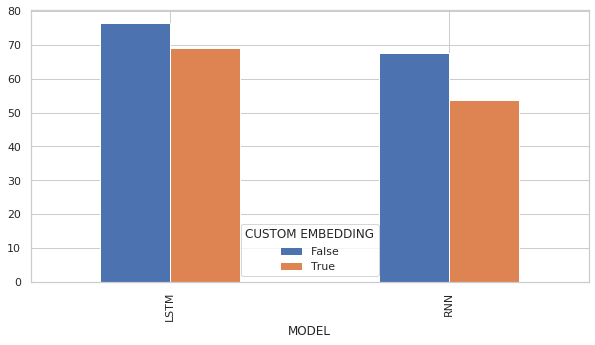

In [79]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(10,5))
results.groupby(['MODEL','CUSTOM EMBEDDING',]).mean()['ACC_TEST'].unstack().plot.bar(ax=ax)

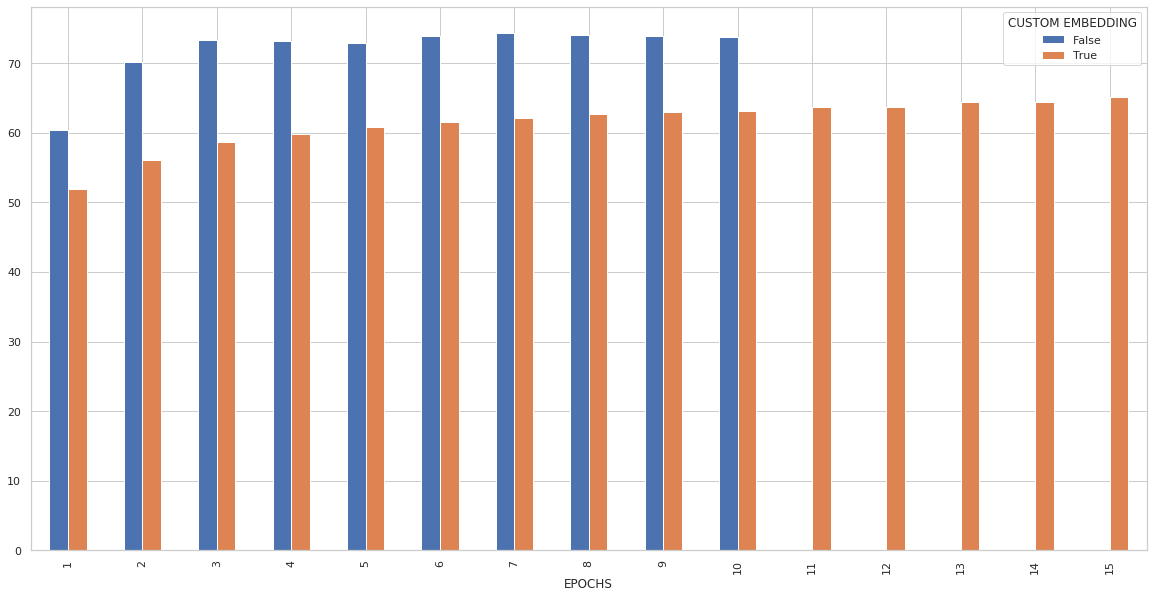

In [84]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
results.groupby(['EPOCHS','CUSTOM EMBEDDING',]).mean()['ACC_TEST'].unstack().plot.bar(ax=ax)

#### LSTM/RNN cells output size impact

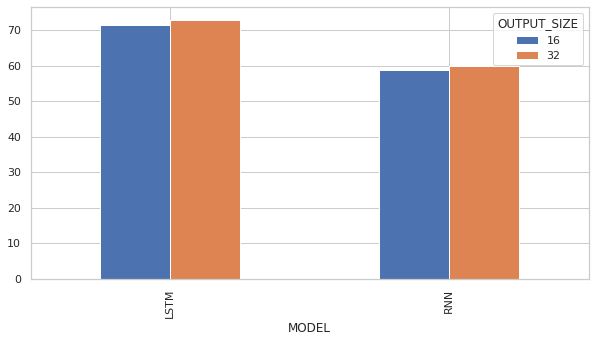

In [73]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(10,5))
results.groupby(['MODEL','OUTPUT_SIZE',]).mean()['ACC_TEST'].unstack().plot.bar(ax=ax)

#### Learning rate impact

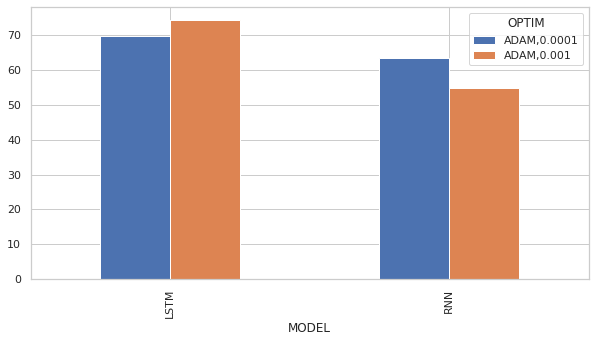

In [74]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(10,5))
results.groupby(['MODEL','OPTIM',]).mean()['ACC_TEST'].unstack().plot.bar(ax=ax)

#### Batch size impact

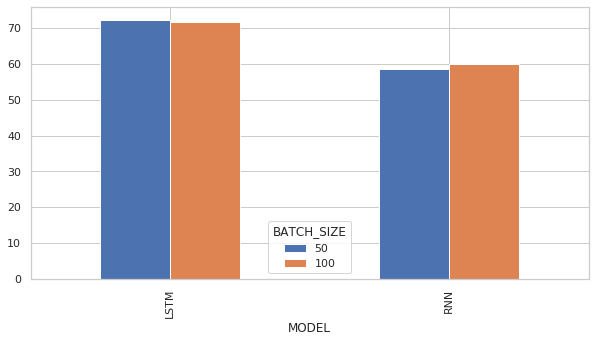

In [75]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(10,5))
results.groupby(['MODEL','BATCH_SIZE',]).mean()['ACC_TEST'].unstack().plot.bar(ax=ax)

### LSTM/RNN comparison

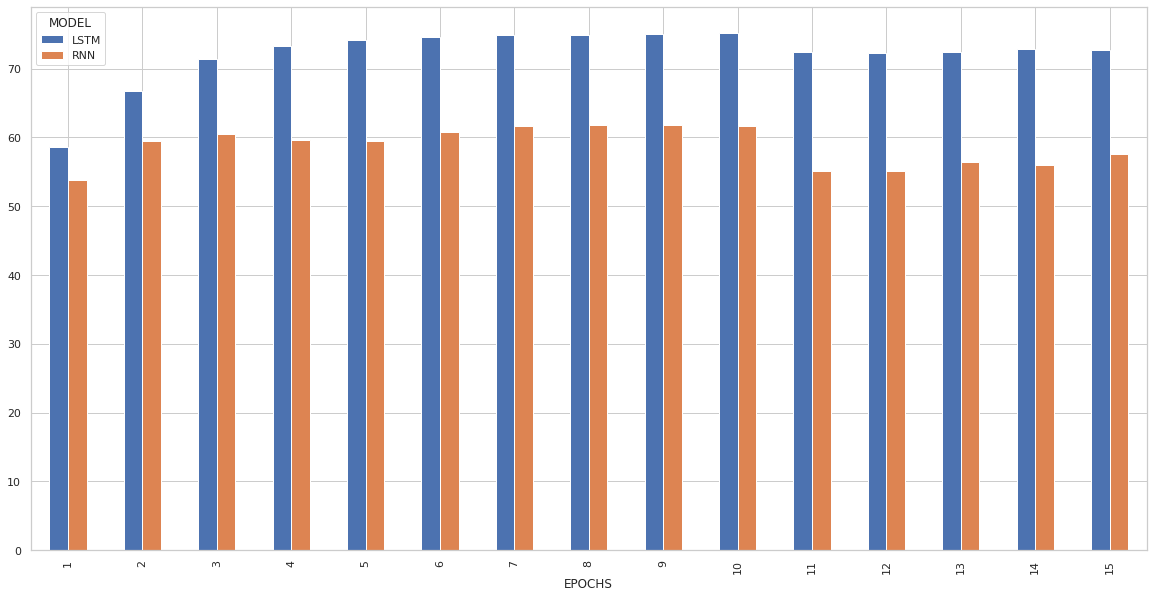

In [76]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
results.groupby(['EPOCHS','MODEL',]).mean()['ACC_TEST'].unstack().plot.bar(ax=ax)

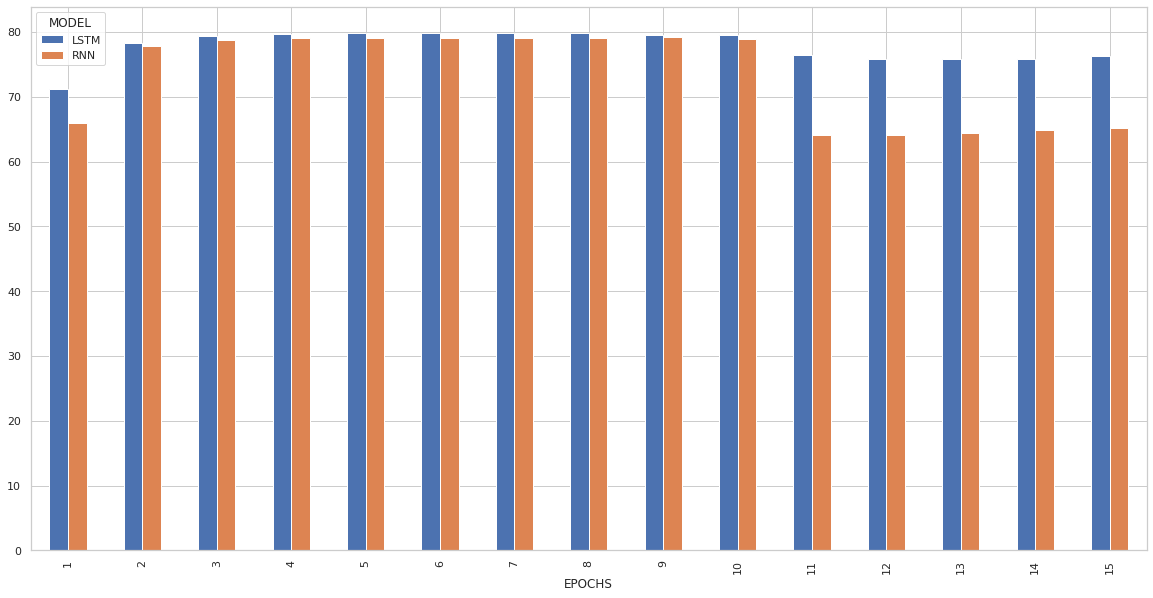

In [77]:
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(20,10))
results.groupby(['EPOCHS','MODEL',]).max()['ACC_TEST'].unstack().plot.bar(ax=ax)

## LSTM i RNN training comparison

In [88]:
rnn_model_best=RNNModel(batch_size=100,output_size=32,custom_embedding_layer=False)
rnn_model_best.fit(x_train,y_train,x_test,y_test,optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

Epoch 1, Loss: 0.6928767561912537, Accuracy: 51.054054260253906, Test Loss: 0.6926246881484985, Test Accuracy: 51.23181915283203
Epoch 2, Loss: 0.6892673373222351, Accuracy: 55.364864349365234, Test Loss: 0.6914845108985901, Test Accuracy: 52.15454864501953
Epoch 3, Loss: 0.6793694496154785, Accuracy: 58.19819641113281, Test Loss: 0.6671293377876282, Test Accuracy: 58.95000076293945
Epoch 4, Loss: 0.49506309628486633, Accuracy: 76.23873901367188, Test Loss: 0.47234708070755005, Test Accuracy: 78.16818237304688
Epoch 5, Loss: 0.4184800684452057, Accuracy: 81.76126098632812, Test Loss: 0.45637744665145874, Test Accuracy: 79.33181762695312
Epoch 6, Loss: 0.39462602138519287, Accuracy: 83.20720672607422, Test Loss: 0.45887160301208496, Test Accuracy: 79.33181762695312
Epoch 7, Loss: 0.38537728786468506, Accuracy: 83.64864349365234, Test Loss: 0.4676268398761749, Test Accuracy: 79.10909271240234
Epoch 8, Loss: 0.3785993754863739, Accuracy: 84.2657699584961, Test Loss: 0.4729941487312317, Te

In [89]:
lstm_model_best=LSTMModel(batch_size=50,output_size=32,custom_embedding_layer=False)
lstm_model_best.fit(x_train,y_train,x_test,y_test,optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

Epoch 1, Loss: 0.6921240091323853, Accuracy: 53.0405387878418, Test Loss: 0.6911011338233948, Test Accuracy: 52.63182067871094
Epoch 2, Loss: 0.652494490146637, Accuracy: 60.39639663696289, Test Loss: 0.5156437158584595, Test Accuracy: 74.8045425415039
Epoch 3, Loss: 0.4426667094230652, Accuracy: 79.590087890625, Test Loss: 0.43594855070114136, Test Accuracy: 79.53182220458984
Epoch 4, Loss: 0.3940862715244293, Accuracy: 82.13063049316406, Test Loss: 0.43440020084381104, Test Accuracy: 79.79545593261719
Epoch 5, Loss: 0.37776097655296326, Accuracy: 83.13964080810547, Test Loss: 0.4346427917480469, Test Accuracy: 79.88636779785156
Epoch 6, Loss: 0.36827027797698975, Accuracy: 83.4549560546875, Test Loss: 0.4468860626220703, Test Accuracy: 79.76818084716797
Epoch 7, Loss: 0.36189699172973633, Accuracy: 83.84684753417969, Test Loss: 0.4435410797595978, Test Accuracy: 79.83636474609375
Epoch 8, Loss: 0.357021689414978, Accuracy: 84.20720672607422, Test Loss: 0.44031885266304016, Test Accur

In [90]:
def visualize_learning(model):
    sns.set()
    fig, (error_subplot, accuracy_subplot) = plt.subplots(1, 2,figsize=(15,5))
    epochs=[i+1 for i in range(len(model.train_learning_accuracy))]
    
    train_errors,test_errors=model.train_learning_losses,model.test_learning_losses
    train_accuracy,test_accuracy=model.train_learning_accuracy,model.test_learning_accuracy

    accuracy_subplot.plot(epochs,train_accuracy,linestyle='--', marker='o', color='green', label='Traing set accuracy')
    accuracy_subplot.plot(epochs,test_accuracy,linestyle='--', marker='o', color='blue', label='Test set accuracy')
    accuracy_subplot.set_title("Model accuracy change per epoch")
    accuracy_subplot.set_xlabel('Epochs')
    accuracy_subplot.set_ylabel('Loss')
    accuracy_subplot.legend(loc="upper left")
    
    error_subplot.plot(epochs,train_errors,linestyle='--', marker='o', color='red',label='Traing set loss')
    error_subplot.plot(epochs,test_errors,linestyle='--', marker='o', color='orange',label='Test set loss')
    error_subplot.set_title("Model loss change per epoch")
    error_subplot.set_xlabel('Epochs')
    error_subplot.set_ylabel('Loss')
    error_subplot.legend(loc="upper right")

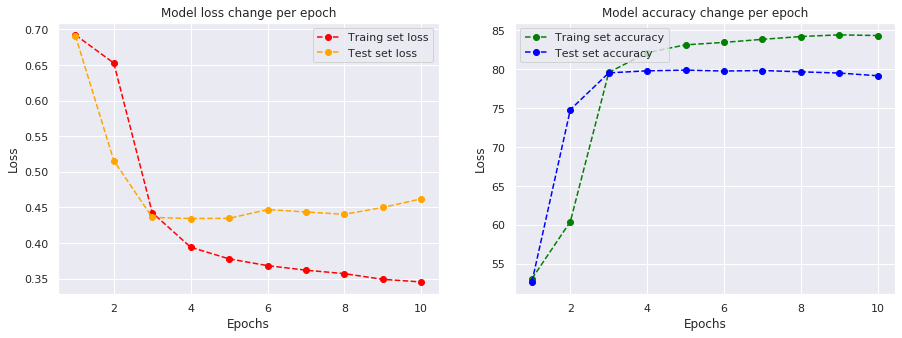

In [91]:
visualize_learning(lstm_model_best)

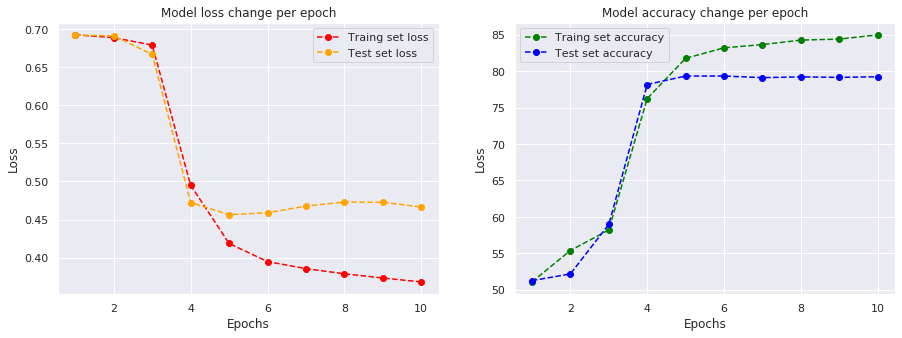

In [92]:
visualize_learning(rnn_model_best)

W komórce LSTM uczenie jest bardziej stabilne.

[[19  4]
 [ 4 23]]
[[40  8]
 [10 42]]


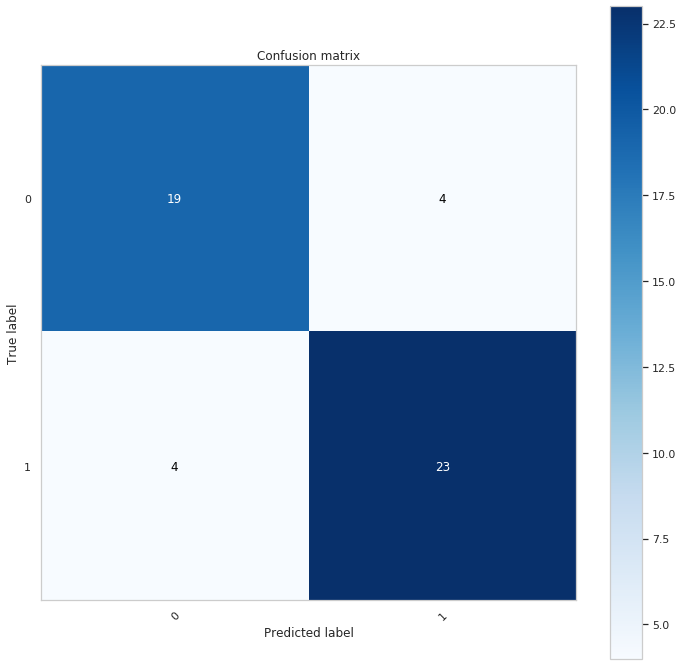

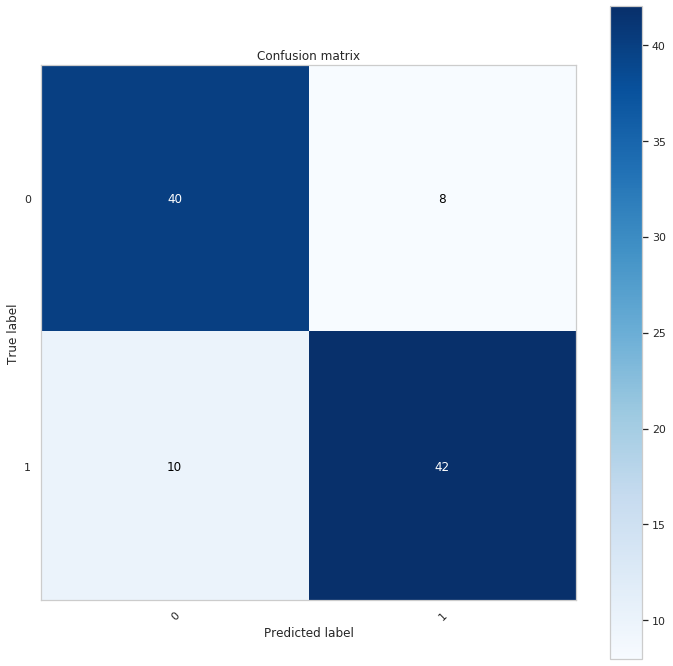

In [94]:
predicted_labels_lstm=lstm_model_best.predict(x_test[0:50])
predicted_labels_rnn=rnn_model_best.predict(x_test[0:100])
ORDERED_CLASS_NAMES=['0','1']
def visualize_confusion_matrix(y_true, y_pred, classes,
                          title=None):

    sns.set_style("whitegrid", {'axes.grid' : False})
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    #setting labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),

           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # label rotation
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # text annotations
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #bug workarond
    ax.set_ylim(len(classes)-0.5, -0.5)
    return ax

visualize_confusion_matrix(y_test[0:50], predicted_labels_lstm, classes=ORDERED_CLASS_NAMES,
                      title='Confusion matrix')
visualize_confusion_matrix(y_test[0:100], predicted_labels_rnn, classes=ORDERED_CLASS_NAMES,
                      title='Confusion matrix')